In [75]:
%pip install pandas
%pip install numpy 
%pip install statsmodels
%pip install matplotlib
%pip install sklearn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'sci

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler


In [2]:
meat_prod_raw = pd.read_csv("../Meat_Stats_Meat_Production.csv")
meat_storage_raw = pd.read_csv("../Meat_Stats_Cold_Storage.csv")
meat_counts_raw = pd.read_csv("../Meat_Stats_Slaughter_Counts.csv")
meat_weights_raw = pd.read_csv("../Meat_Stats_Slaughter_Weights.csv")

normalized_etf_yearly = pd.read_csv('../variables_of_interest/normalized_etf_yearly.csv')
normalized_etf_monthly = pd.read_csv('../variables_of_interest/normalized_etf_monthly.csv')

## Process Meat Dataset

In [3]:
# clean production data
meat_prod_processed = meat_prod_raw.copy()
meat_prod_processed['Production'] = meat_prod_processed['Production'].str.replace(",", "").astype(float)
meat_prod_processed.drop(['Unit', 'Year', 'Month', 'Commercial or Federally Inspected'], axis=1, inplace=True)
meat_prod_processed.dropna(inplace=True)
meat_prod_processed['Date'] = pd.to_datetime(meat_prod_processed['Date'])
meat_prod_processed.reset_index(drop=True, inplace=True)
#meat_prod_processed = meat_prod_processed.groupby(['Date', 'Animal']).sum().reset_index()
meat_prod_monthly = meat_prod_processed.copy()
meat_prod_processed


/var/folders/1x/443khrvj3wxbl0fy_v6jmhjh0000gn/T/ipykernel_4842/4143624193.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  meat_prod_processed['Date'] = pd.to_datetime(meat_prod_processed['Date'])


,Date,Production,Animal,Type of Meat
0,2023-12-01,2189.8,Beef,Red Meat
1,2023-11-01,2280.9,Beef,Red Meat
2,2023-10-01,2340.9,Beef,Red Meat
3,2023-09-01,2149.4,Beef,Red Meat
4,2023-08-01,2363.5,Beef,Red Meat
...,...,...,...,...
9615,1960-06-01,27.1,Turkey,Poultry
9616,1960-05-01,16.2,Turkey,Poultry
9617,1960-04-01,13.4,Turkey,Poultry
9618,1960-03-01,14.0,Turkey,Poultry


In [4]:
meat_prod_processed['Date'] = pd.to_datetime(meat_prod_processed['Date'])

meat_prod_processed['Year'] = meat_prod_processed['Date'].dt.year

meat_prod_processed.drop(columns=['Date'], inplace=True)

meat_prod_processed.dropna(inplace=True)

meat_prod_processed

,Production,Animal,Type of Meat,Year
0,2189.8,Beef,Red Meat,2023
1,2280.9,Beef,Red Meat,2023
2,2340.9,Beef,Red Meat,2023
3,2149.4,Beef,Red Meat,2023
4,2363.5,Beef,Red Meat,2023
...,...,...,...,...
9615,27.1,Turkey,Poultry,1960
9616,16.2,Turkey,Poultry,1960
9617,13.4,Turkey,Poultry,1960
9618,14.0,Turkey,Poultry,1960


In [5]:
unique_meats= meat_prod_processed['Animal'].unique()
unique_meats

array(['Beef', 'Veal', 'Pork', 'Lamb and Mutton', 'Broilers',
       'Other Chicken', 'Turkey'], dtype=object)

In [6]:
meat_prod_processed['Production'] = pd.to_numeric(meat_prod_processed['Production'], errors='coerce')

meat_prod_processed.dropna(subset=['Production'], inplace=True)

grouped_meat_df = meat_prod_processed.groupby(['Animal', 'Year'])['Production'].mean().reset_index()
grouped_meat_df = grouped_meat_df[(grouped_meat_df['Year'] > 1989)]
grouped_meat_df


,Animal,Year,Production
69,Beef,1990,1866.083333
70,Beef,1991,1880.875000
71,Beef,1992,1895.500000
72,Beef,1993,1894.583333
73,Beef,1994,2006.291667
...,...,...,...
559,Veal,2019,6.137500
560,Veal,2020,5.279167
561,Veal,2021,4.375000
562,Veal,2022,4.429167


## Merge with ETFs

In [7]:
normalized_etf_yearly

,Unnamed: 0,Year,ETF,Price,Volatility
0,0,1999,Agri_Machinery_ETF,35.896562,18.041195
1,1,1999,Food_Beverage_ETF,38.574624,16.331450
2,2,1999,Investment_Funds_ETF,127.576142,21.784007
3,3,1999,Restaurant_FastFood_ETF,33.656642,12.122728
4,4,1999,Retail_ETF,16.157612,0.000000
...,...,...,...,...,...
125,125,2024,Agri_Machinery_ETF,275.591445,132.439912
126,126,2024,Food_Beverage_ETF,423.274203,272.971293
127,127,2024,Investment_Funds_ETF,383.809935,194.383929
128,128,2024,Restaurant_FastFood_ETF,1523.165088,812.518782


In [8]:
grouped_meat_df = grouped_meat_df[grouped_meat_df['Animal'].isin(['Beef', 'Veal', 'Pork', 'Lamb and Mutton', 'Broilers',
       'Other Chicken', 'Turkey'])]

grouped_meat_df = grouped_meat_df.pivot(index='Year', columns='Animal', values='Production').reset_index()

grouped_meat_df.columns.name = None

grouped_meat_df.dropna(inplace=True)

grouped_meat_df


,Year,Beef,Broilers,Lamb and Mutton,Other Chicken,Pork,Turkey,Veal
11,2001,2160.416667,2605.483333,18.250000,42.991667,1584.958333,462.108333,15.916667
12,2002,2241.791667,2686.650000,17.775000,45.591667,1629.166667,472.433333,16.045833
13,2003,2171.541667,2729.083333,16.266667,41.883333,1653.500000,472.858333,15.712500
14,2004,2030.791667,2838.616667,15.804167,42.016667,1701.416667,454.466667,13.691667
15,2005,2042.125000,2947.066667,15.279167,43.033333,1716.308333,458.883333,12.812500
16,2006,2164.316667,2958.300000,15.104167,42.050000,1747.129167,474.183333,12.095833
17,2007,2187.100000,3013.250000,14.904167,41.516667,1821.275000,493.241667,11.312500
18,2008,2198.375000,3075.525000,14.141667,46.608333,1938.195833,517.975000,11.800000
19,2009,2148.470833,2959.200000,13.850000,41.675000,1909.408333,474.933333,11.400000
20,2010,2177.437500,3075.816667,13.241667,41.991667,1862.962500,469.933333,11.037500


In [9]:
grouped_meat_df.to_csv('../variables_of_interest/meat_yearly.csv')

In [10]:
def merge_datasets(health_df, stock_df):
    stock_df_pivot = stock_df.pivot(index='Year', columns='ETF', values='Price').reset_index()
    merged_data = pd.merge(health_df, stock_df_pivot, on='Year', how='inner')
    return merged_data

temp_df2 = merge_datasets(grouped_meat_df, normalized_etf_yearly[['Year', 'ETF', 'Price']])
temp_df2.to_csv("data/etf_normalized_vs_meat.csv")

temp_df2['Year'] = pd.to_numeric(temp_df2['Year'], errors='coerce')

In [11]:
temp_df2

,Year,Beef,Broilers,Lamb and Mutton,Other Chicken,Pork,Turkey,Veal,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
0,2001,2160.416667,2605.483333,18.250000,42.991667,1584.958333,462.108333,15.916667,34.254688,39.818914,111.495747,30.839901,19.521388
1,2002,2241.791667,2686.650000,17.775000,45.591667,1629.166667,472.433333,16.045833,37.347221,42.960852,96.263762,29.173835,46.395311
2,2003,2171.541667,2729.083333,16.266667,41.883333,1653.500000,472.858333,15.712500,42.520626,44.428565,91.971963,23.858357,41.224514
3,2004,2030.791667,2838.616667,15.804167,42.016667,1701.416667,454.466667,13.691667,55.550495,45.953000,100.698620,29.976459,37.561603
4,2005,2042.125000,2947.066667,15.279167,43.033333,1716.308333,458.883333,12.812500,55.327880,45.615803,105.049110,36.067338,46.506956
5,2006,2164.316667,2958.300000,15.104167,42.050000,1747.129167,474.183333,12.095833,61.071520,46.000083,113.389157,40.772488,53.057327
6,2007,2187.100000,3013.250000,14.904167,41.516667,1821.275000,493.241667,11.312500,81.257501,48.331924,129.130469,51.569991,47.890320
7,2008,2198.375000,3075.525000,14.141667,46.608333,1938.195833,517.975000,11.800000,63.930424,42.753783,108.620870,45.183808,36.979868
8,2009,2148.470833,2959.200000,13.850000,41.675000,1909.408333,474.933333,11.400000,43.404134,39.882186,86.688138,44.807149,42.165084
9,2010,2177.437500,3075.816667,13.241667,41.991667,1862.962500,469.933333,11.037500,61.678449,44.504493,102.766500,78.241386,55.456225


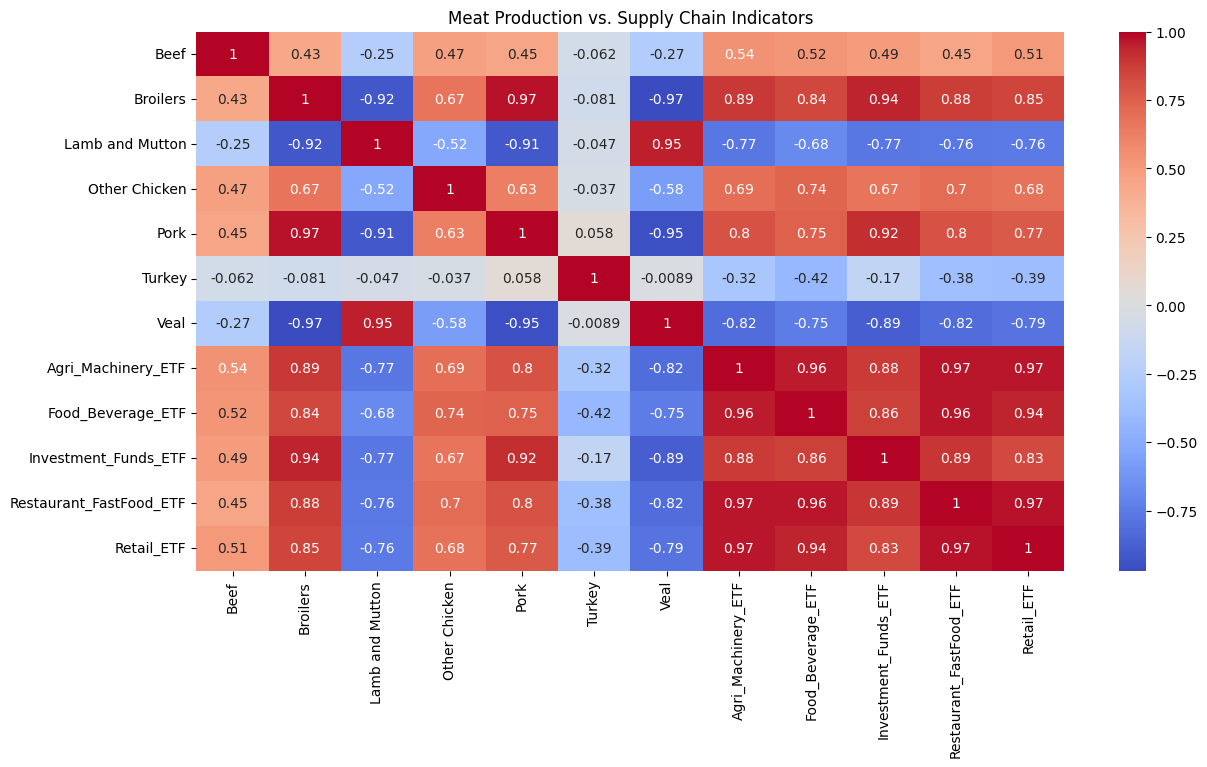

,Beef,Broilers,Lamb and Mutton,Other Chicken,Pork,Turkey,Veal,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
Beef,1.000000,0.431914,-0.249854,0.473807,0.451910,-0.062129,-0.266367,0.539751,0.524389,0.492597,0.446401,0.507655
Broilers,0.431914,1.000000,-0.921838,0.670850,0.973522,-0.080938,-0.969271,0.887683,0.844374,0.944267,0.876720,0.849460
Lamb and Mutton,-0.249854,-0.921838,1.000000,-0.518075,-0.913105,-0.047268,0.953688,-0.772126,-0.683340,-0.772922,-0.763545,-0.760240
Other Chicken,0.473807,0.670850,-0.518075,1.000000,0.625769,-0.036744,-0.582319,0.692540,0.738129,0.673965,0.703087,0.677024
Pork,0.451910,0.973522,-0.913105,0.625769,1.000000,0.057779,-0.950329,0.804032,0.753839,0.917445,0.803890,0.770775
Turkey,-0.062129,-0.080938,-0.047268,-0.036744,0.057779,1.000000,-0.008851,-0.319839,-0.421133,-0.174143,-0.376124,-0.385343
Veal,-0.266367,-0.969271,0.953688,-0.582319,-0.950329,-0.008851,1.000000,-0.820863,-0.750034,-0.887506,-0.820326,-0.787767
Agri_Machinery_ETF,0.539751,0.887683,-0.772126,0.692540,0.804032,-0.319839,-0.820863,1.000000,0.961173,0.880904,0.967444,0.965774
Food_Beverage_ETF,0.524389,0.844374,-0.683340,0.738129,0.753839,-0.421133,-0.750034,0.961173,1.000000,0.862096,0.961597,0.940508
Investment_Funds_ETF,0.492597,0.944267,-0.772922,0.673965,0.917445,-0.174143,-0.887506,0.880904,0.862096,1.000000,0.892631,0.831268


In [12]:
def plt_corr_matrix(df, question):
    if 'Year' in df.columns:
        if df['Year'].dtype not in ['int64', 'float64']:
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    if 'Year' in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=['Year'])
    
    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(14, 7))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(question)
    plt.show()

    return corr_matrix

plt_corr_matrix(temp_df2, "Meat Production vs. Supply Chain Indicators")

## Monthly Meat Production vs Monthly ETFs

In [13]:
meat_prod_monthly

,Date,Production,Animal,Type of Meat
0,2023-12-01,2189.8,Beef,Red Meat
1,2023-11-01,2280.9,Beef,Red Meat
2,2023-10-01,2340.9,Beef,Red Meat
3,2023-09-01,2149.4,Beef,Red Meat
4,2023-08-01,2363.5,Beef,Red Meat
...,...,...,...,...
9615,1960-06-01,27.1,Turkey,Poultry
9616,1960-05-01,16.2,Turkey,Poultry
9617,1960-04-01,13.4,Turkey,Poultry
9618,1960-03-01,14.0,Turkey,Poultry


In [14]:
meat_prod_monthly['Date'] = pd.to_datetime(meat_prod_monthly['Date'])

# Extract year and month from 'Date' column
meat_prod_monthly['Year'] = meat_prod_monthly['Date'].dt.year
meat_prod_monthly['Month'] = meat_prod_monthly['Date'].dt.month

# Drop 'Date' column
meat_prod_monthly.drop(columns=['Date'], inplace=True)

# Drop any remaining NaN values
meat_prod_monthly.dropna(inplace=True)

meat_prod_monthly

,Production,Animal,Type of Meat,Year,Month
0,2189.8,Beef,Red Meat,2023,12
1,2280.9,Beef,Red Meat,2023,11
2,2340.9,Beef,Red Meat,2023,10
3,2149.4,Beef,Red Meat,2023,9
4,2363.5,Beef,Red Meat,2023,8
...,...,...,...,...,...
9615,27.1,Turkey,Poultry,1960,6
9616,16.2,Turkey,Poultry,1960,5
9617,13.4,Turkey,Poultry,1960,4
9618,14.0,Turkey,Poultry,1960,3


In [15]:
meat_prod_monthly[(meat_prod_monthly['Year'] == 2023) & (meat_prod_monthly['Month'] == 12)]

,Production,Animal,Type of Meat,Year,Month
0,2189.8,Beef,Red Meat,2023,12
952,3.9,Veal,Red Meat,2023,12
1904,2342.0,Pork,Red Meat,2023,12
2856,10.7,Lamb and Mutton,Red Meat,2023,12
3808,2158.9,Beef,Red Meat,2023,12
4808,3.7,Veal,Red Meat,2023,12
5808,2332.4,Pork,Red Meat,2023,12
6808,9.5,Lamb and Mutton,Red Meat,2023,12
7808,3615.0,Broilers,Poultry,2023,12
8576,41.5,Other Chicken,Poultry,2023,12


In [16]:
meat_prod_monthly['Production'] = pd.to_numeric(meat_prod_processed['Production'], errors='coerce')

meat_prod_monthly.dropna(subset=['Production'], inplace=True)

meat_avg_prod_monthly = meat_prod_monthly.copy()

meat_avg_prod_monthly = meat_avg_prod_monthly.groupby(['Animal', 'Year', 'Month'])['Production'].mean().reset_index()
meat_avg_prod_monthly = meat_avg_prod_monthly[(meat_avg_prod_monthly['Year'] > 1989)]
meat_avg_prod_monthly

,Animal,Year,Month,Production
820,Beef,1990,1,1911.00
821,Beef,1990,2,1687.50
822,Beef,1990,3,1850.00
823,Beef,1990,4,1728.50
824,Beef,1990,5,1986.00
...,...,...,...,...
6719,Veal,2023,8,4.15
6720,Veal,2023,9,3.55
6721,Veal,2023,10,4.10
6722,Veal,2023,11,4.20


In [17]:
grouped_monthly_meat_df = meat_avg_prod_monthly[meat_avg_prod_monthly['Animal'].isin(['Beef', 'Veal', 'Pork', 'Lamb and Mutton', 'Broilers',
       'Other Chicken', 'Turkey'])]

grouped_monthly_meat_df = grouped_monthly_meat_df.pivot(index=['Year', 'Month'], columns='Animal', values='Production').reset_index()

grouped_monthly_meat_df.columns.name = None

grouped_monthly_meat_df.dropna(inplace=True)

grouped_monthly_meat_df

,Year,Month,Beef,Broilers,Lamb and Mutton,Other Chicken,Pork,Turkey,Veal
132,2001,1,2188.50,2622.2,18.50,42.7,1682.50,403.4,17.50
133,2001,2,1866.50,2322.2,17.00,39.7,1476.50,461.2,15.50
134,2001,3,2080.50,2588.6,23.00,44.4,1616.00,409.3,16.00
135,2001,4,1924.50,2515.7,19.50,42.2,1523.50,462.0,15.00
136,2001,5,2279.50,2835.6,16.50,45.6,1545.00,428.8,15.50
...,...,...,...,...,...,...,...,...,...
403,2023,8,2346.50,4156.7,9.70,51.1,2288.70,433.5,4.15
404,2023,9,2132.00,3805.5,9.40,48.4,2180.85,489.2,3.55
405,2023,10,2320.85,4177.3,10.55,50.6,2412.35,431.2,4.10
406,2023,11,2264.10,3817.3,10.65,44.5,2382.80,500.3,4.20


In [18]:
grouped_monthly_meat_df.to_csv('../variables_of_interest/meat_monthly.csv')

In [19]:
#etf_monthly = etf_monthly[['Year', 'Month', 'ETF', 'Price']]
#etf_monthly
normalized_etf_monthly = normalized_etf_monthly[['Year', 'Month', 'ETF', 'Price']]
normalized_etf_monthly

,Year,Month,ETF,Price
0,1999,11,Agri_Machinery_ETF,36.835142
1,1999,11,Food_Beverage_ETF,40.019708
2,1999,11,Investment_Funds_ETF,125.522357
3,1999,11,Restaurant_FastFood_ETF,34.920701
4,1999,11,Retail_ETF,17.868213
...,...,...,...,...
1455,2024,2,Agri_Machinery_ETF,277.317478
1456,2024,2,Food_Beverage_ETF,421.236543
1457,2024,2,Investment_Funds_ETF,391.489413
1458,2024,2,Restaurant_FastFood_ETF,1607.725593


In [20]:
def merge_datasets_2(health_df, stock_df):
    stock_df_pivot = stock_df.pivot(index=['Year', 'Month'], columns='ETF', values='Price').reset_index()
    merged_data = pd.merge(health_df, stock_df_pivot, on=['Year', 'Month'], how='inner')
    return merged_data

#monthly_df_merged = merge_datasets_2(grouped_monthly_meat_df, etf_monthly)
monthly_df_merged2 = merge_datasets_2(grouped_monthly_meat_df, normalized_etf_monthly)

In [21]:
#monthly_df_merged.to_csv('etf_vs_meat_monthly.csv')
#monthly_df_merged
monthly_df_merged2.to_csv('data/etf_normalized_vs_meat_monthly.csv')
monthly_df_merged2

,Year,Month,Beef,Broilers,Lamb and Mutton,Other Chicken,Pork,Turkey,Veal,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
0,2001,1,2188.50,2622.2,18.50,42.7,1682.50,403.4,17.50,33.760939,38.209637,122.230382,33.100672,12.277433
1,2001,2,1866.50,2322.2,17.00,39.7,1476.50,461.2,15.50,32.894615,39.825062,119.987399,34.349403,14.138910
2,2001,3,2080.50,2588.6,23.00,44.4,1616.00,409.3,16.00,32.713920,39.575668,109.398792,32.910808,14.203782
3,2001,4,1924.50,2515.7,19.50,42.2,1523.50,462.0,15.00,32.404285,38.372724,111.369127,32.308881,14.097942
4,2001,5,2279.50,2835.6,16.50,45.6,1545.00,428.8,15.50,35.201656,38.608391,120.074168,29.177770,15.600822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2023,8,2346.50,4156.7,9.70,51.1,2288.70,433.5,4.15,278.897895,344.993909,342.392789,1164.050862,219.832935
272,2023,9,2132.00,3805.5,9.40,48.4,2180.85,489.2,3.55,271.175546,329.066365,338.914651,1176.277724,211.588589
273,2023,10,2320.85,4177.3,10.55,50.6,2412.35,431.2,4.10,253.592562,316.868611,329.718627,1142.686074,198.630677
274,2023,11,2264.10,3817.3,10.65,44.5,2382.80,500.3,4.20,249.251962,342.498279,345.688258,1314.577751,199.673985


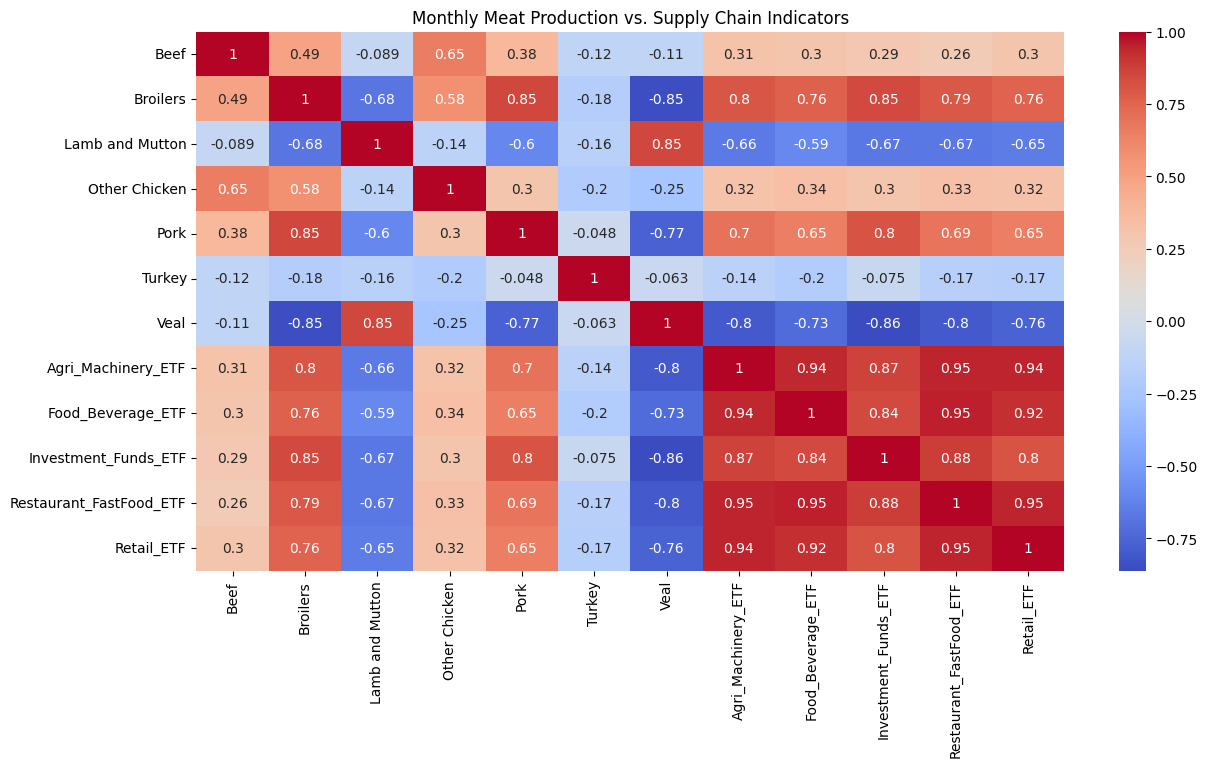

,Beef,Broilers,Lamb and Mutton,Other Chicken,Pork,Turkey,Veal,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
Beef,1.000000,0.489901,-0.089449,0.651486,0.375721,-0.118507,-0.113989,0.312723,0.298718,0.287416,0.257296,0.295218
Broilers,0.489901,1.000000,-0.683872,0.577813,0.854043,-0.177994,-0.847467,0.802946,0.761182,0.846432,0.793787,0.758044
Lamb and Mutton,-0.089449,-0.683872,1.000000,-0.137570,-0.599356,-0.158688,0.847468,-0.664343,-0.593146,-0.668359,-0.666796,-0.651346
Other Chicken,0.651486,0.577813,-0.137570,1.000000,0.299868,-0.201724,-0.250360,0.316282,0.336971,0.296026,0.328948,0.319382
Pork,0.375721,0.854043,-0.599356,0.299868,1.000000,-0.047627,-0.770718,0.700828,0.649641,0.803761,0.692820,0.650319
Turkey,-0.118507,-0.177994,-0.158688,-0.201724,-0.047627,1.000000,-0.063368,-0.142359,-0.197676,-0.075091,-0.166260,-0.174194
Veal,-0.113989,-0.847467,0.847468,-0.250360,-0.770718,-0.063368,1.000000,-0.799331,-0.726277,-0.860891,-0.797538,-0.761937
Agri_Machinery_ETF,0.312723,0.802946,-0.664343,0.316282,0.700828,-0.142359,-0.799331,1.000000,0.937638,0.866943,0.945785,0.942039
Food_Beverage_ETF,0.298718,0.761182,-0.593146,0.336971,0.649641,-0.197676,-0.726277,0.937638,1.000000,0.842973,0.952635,0.917556
Investment_Funds_ETF,0.287416,0.846432,-0.668359,0.296026,0.803761,-0.075091,-0.860891,0.866943,0.842973,1.000000,0.877191,0.804848


In [22]:
def plt_corr_matrix_month(df, question):
    if 'Year' in df.columns:
        if df['Year'].dtype not in ['int64', 'float64']:
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    if 'Year' in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=['Year'])
    if 'Month' in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=['Month'])
    
    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(14, 7))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(question)
    plt.show()

    return corr_matrix
plt_corr_matrix_month(monthly_df_merged2, "Monthly Meat Production vs. Supply Chain Indicators")

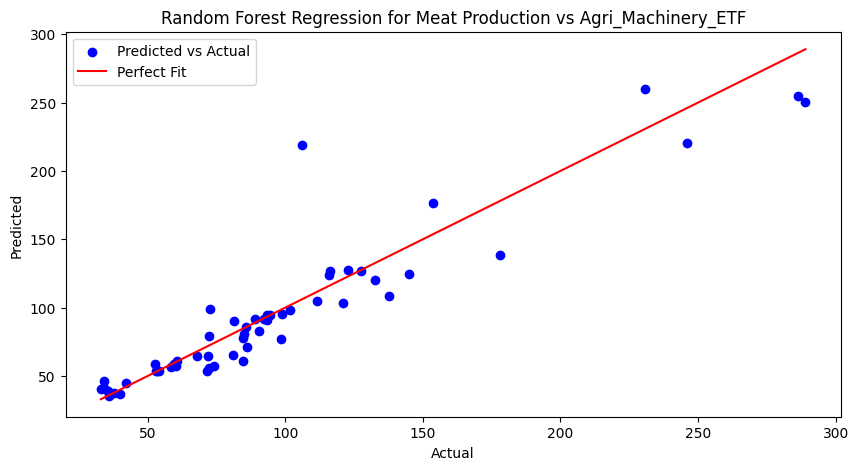

ETF: Agri_Machinery_ETF, MSE: 437.66, R^2: 0.87
Feature Importances: [0.00910528 0.01550002 0.0077995  0.00596742 0.01822587 0.00993229
 0.93346962]


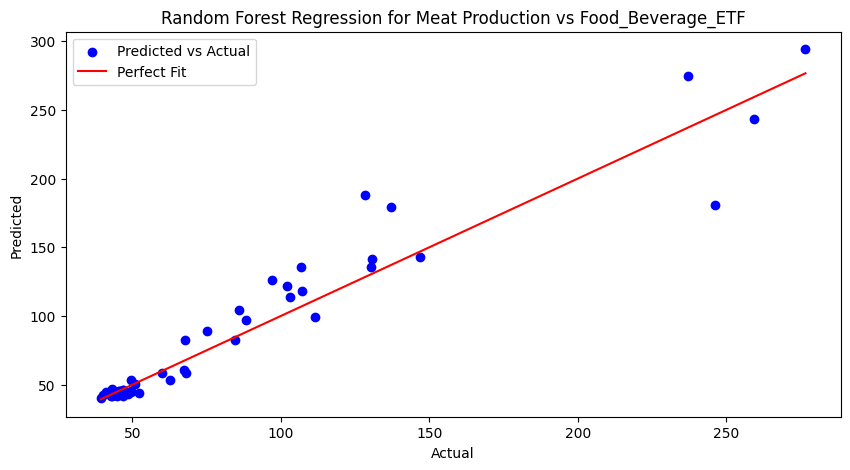

ETF: Food_Beverage_ETF, MSE: 277.05, R^2: 0.91
Feature Importances: [0.01599699 0.01751257 0.00941668 0.02398344 0.02076741 0.0179927
 0.89433021]


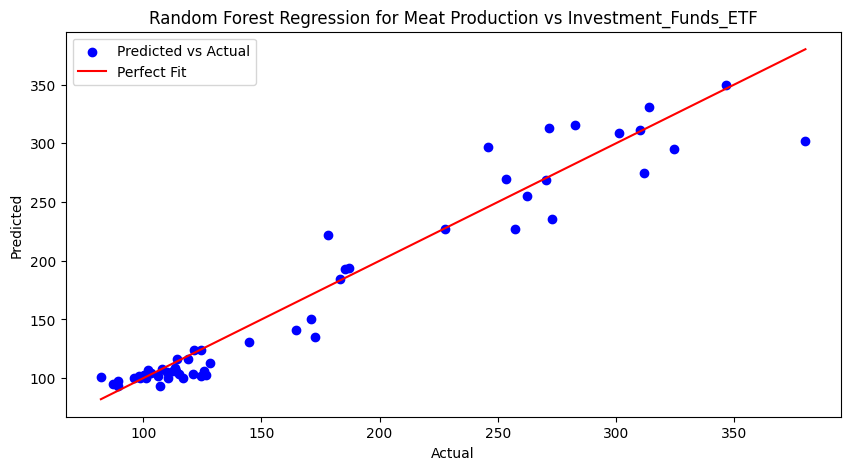

ETF: Investment_Funds_ETF, MSE: 441.44, R^2: 0.94
Feature Importances: [0.01689848 0.02158076 0.01131754 0.01017674 0.02182439 0.00700516
 0.91119693]


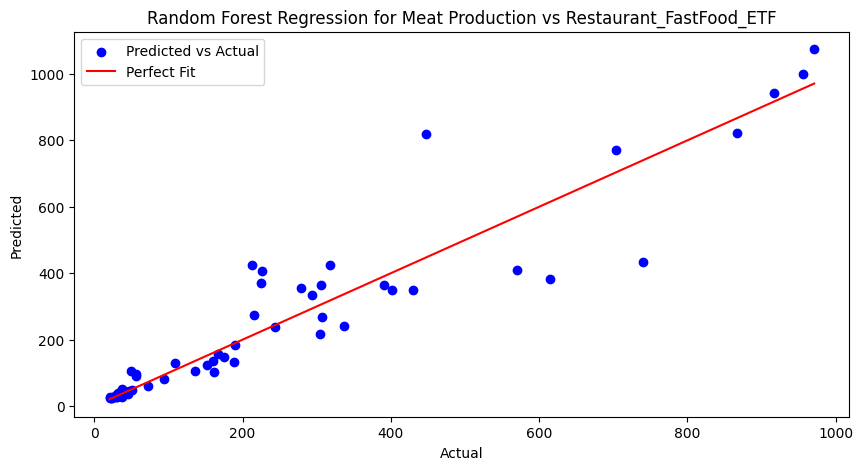

ETF: Restaurant_FastFood_ETF, MSE: 8962.69, R^2: 0.87
Feature Importances: [0.00758954 0.01283239 0.00602598 0.00909315 0.00863638 0.00976495
 0.94605761]


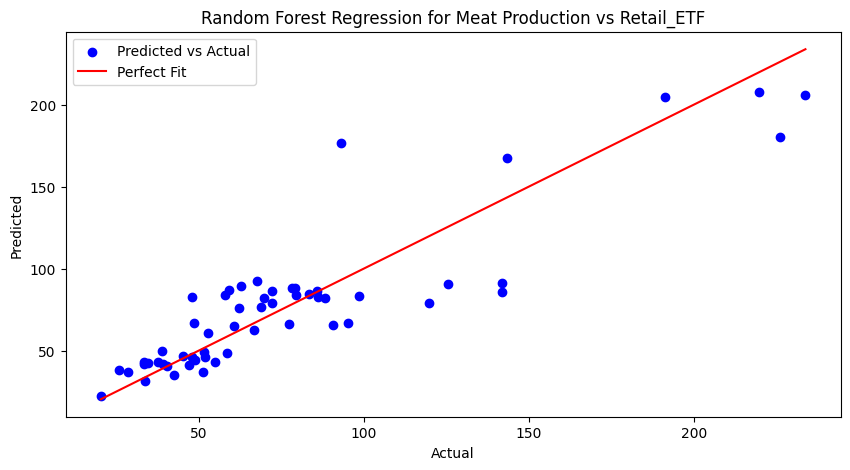

ETF: Retail_ETF, MSE: 492.40, R^2: 0.79
Feature Importances: [0.01210898 0.01515897 0.01395084 0.00813989 0.01485582 0.01143893
 0.92434658]


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

monthly_df_merged3 = monthly_df_merged2.copy()
#monthly_df_merged3 = monthly_df_merged3.drop(columns=['Veal'])

etfs = ['Agri_Machinery_ETF', 'Food_Beverage_ETF', 'Investment_Funds_ETF', 'Restaurant_FastFood_ETF', 'Retail_ETF']

def evaluate_rf_regression_multiple_features(etf):
    X = monthly_df_merged3[['Beef', 'Broilers', 'Lamb and Mutton', 'Other Chicken', 'Pork', 'Turkey','Veal']]  
    y = monthly_df_merged3[etf]  # ETF value as the target

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on test set
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Feature importance
    importance = rf_model.feature_importances_

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Fit')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Random Forest Regression for Meat Production vs {etf}')
    plt.legend()
    plt.show()

    return mse, r2, importance

# Evaluate for each ETF
for etf in etfs:
    mse, r2, importance = evaluate_rf_regression_multiple_features(etf)
    print(f'ETF: {etf}, MSE: {mse:.2f}, R^2: {r2:.2f}')
    print(f'Feature Importances: {importance}')